## <center>Melanoma Skin Cancer Detection</center>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [87]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import glob
import PIL
import Augmentor
from tensorflow import keras
from keras import layers
from keras import regularizers

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/Data/Melanoma_Detection_Data/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Data/Melanoma_Detection_Data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Training Dataset

train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation Dataset

val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Classes

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

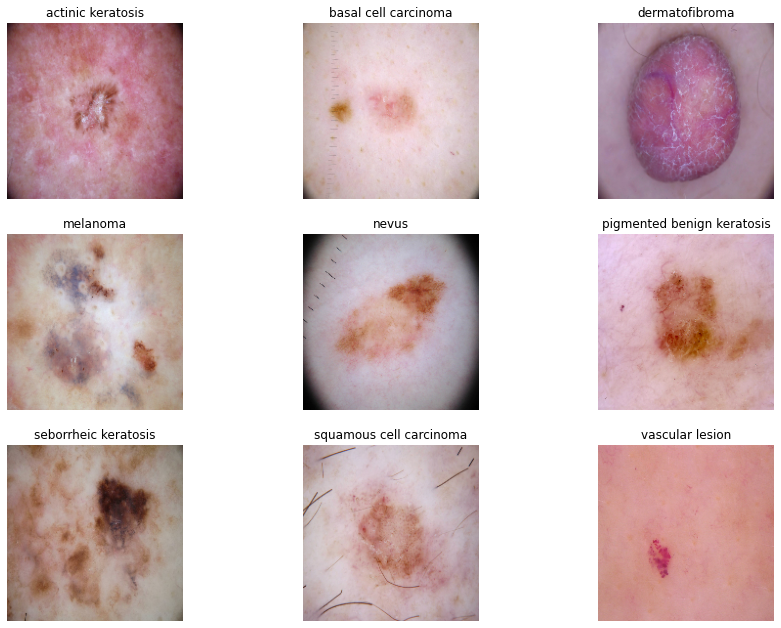

In [9]:
plt.figure(figsize=(15, 11))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
# model definition

model = keras.Sequential([
                          layers.Rescaling(1./255),
                          layers.Conv2D(32, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(64, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(128, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(9, activation="softmax")
])

### Compile the model

In [12]:
# optimizer, loss, metrics choices

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Train the model

In [13]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

Epoch 1/20
56/56 [==============================] - 87s 907ms/step - loss: 2.3346 - accuracy: 0.2316 - val_loss: 1.9402 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.8659 - accuracy: 0.3181 - val_loss: 1.7882 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.7628 - accuracy: 0.4230 - val_loss: 1.9834 - val_accuracy: 0.3087
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6348 - accuracy: 0.4459 - val_loss: 2.0695 - val_accuracy: 0.3132
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5554 - accuracy: 0.4487 - val_loss: 1.6714 - val_accuracy: 0.4161
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4429 - accuracy: 0.5073 - val_loss: 1.8260 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3623 - accuracy: 0.5195 - val_loss: 1.8394 - val_accuracy: 0.4027
Epoch 8/20


### Visualizing training results

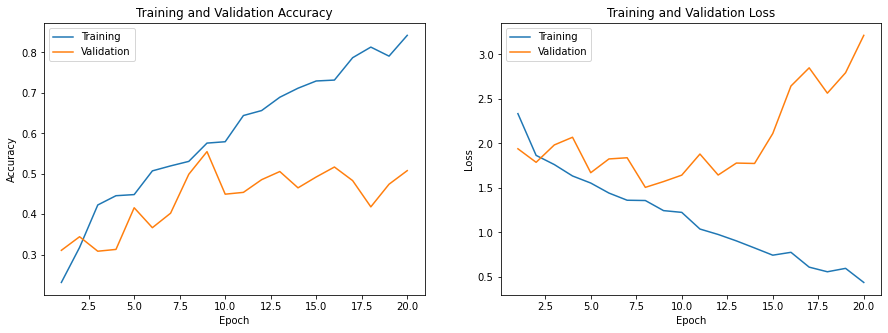

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- The model starts to overfit after 10 epochs
- Most probably this is due to lack of sufficient data
- Let's apply data augmentation to improve the variety of data
- Additionally, adding dropout can help mitigate overfitting

In [15]:
# random horizontal flip, upto 20 % rotation in either direction, upto 20 % zoom

data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.2),
                                      layers.RandomZoom(0.2)
])

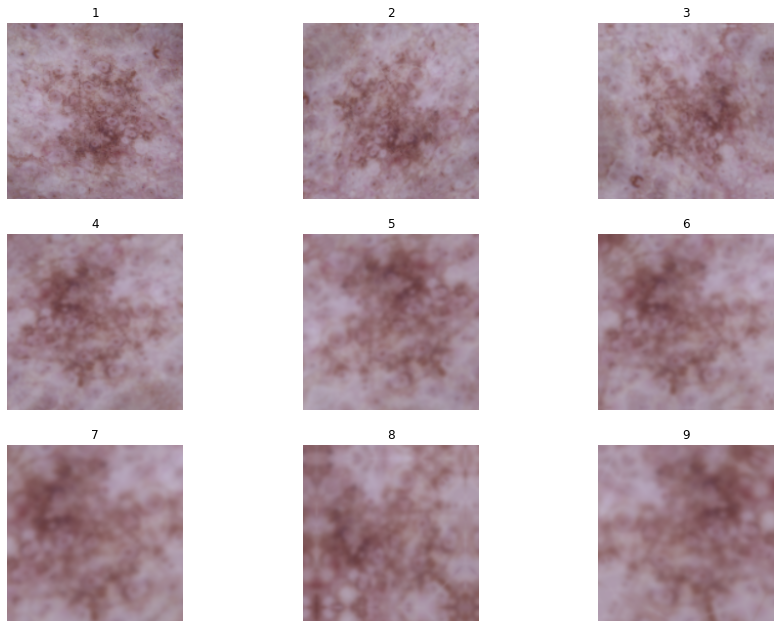

In [22]:
plt.figure(figsize=(15, 11))
for element in train_ds:
    img = element[0][0].numpy().astype('uint8')
    for i in range(9):
        img = data_augmentation(img)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy().astype('uint8'))
        plt.title(f"{i + 1}")
        plt.axis("off")
    break

### Create, compile and train the model


In [24]:
# model definition

model_2 = keras.Sequential([
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(32, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(64, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(128, 3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(128, activation="relu"),
                          layers.Dropout(0.5),
                          layers.Dense(9, activation="softmax")
])

### Compiling the model

In [25]:
model_2.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Training the model

In [26]:
history = model_2.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 2.4547 - accuracy: 0.2070 - val_loss: 1.9560 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 2.0035 - accuracy: 0.2768 - val_loss: 1.8328 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.8747 - accuracy: 0.3248 - val_loss: 1.6408 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7953 - accuracy: 0.3644 - val_loss: 1.7572 - val_accuracy: 0.3803
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7855 - accuracy: 0.3767 - val_loss: 1.6617 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7297 - accuracy: 0.4062 - val_loss: 1.6149 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6862 - accuracy: 0.4152 - val_loss: 1.6294 - val_accuracy: 0.4676
Epoch 8/20
56

### Visualizing the results

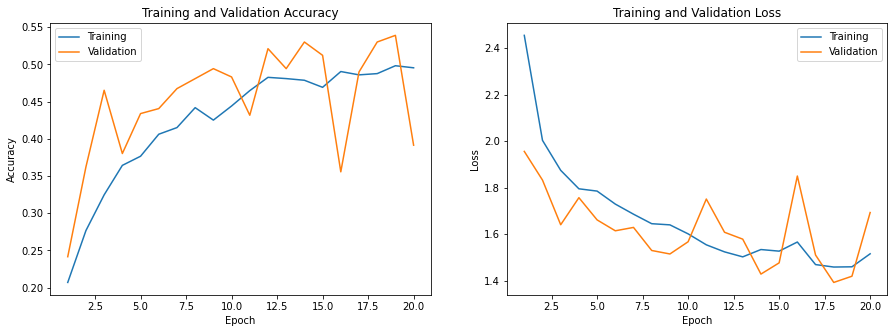

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- The model underfits the data after applying data augmentation and dropout 
- The model trained faster as compared to previous run of the model

Let's check the distribution of classes in the training dataset.

In [34]:
num_samples_per_class = []
for class_name in class_names:
    samples_list = os.listdir(f"{data_dir_train}/{class_name}")
    num_samples_per_class.append(len(samples_list))
num_samples_per_class

[114, 376, 95, 438, 357, 462, 77, 181, 139]

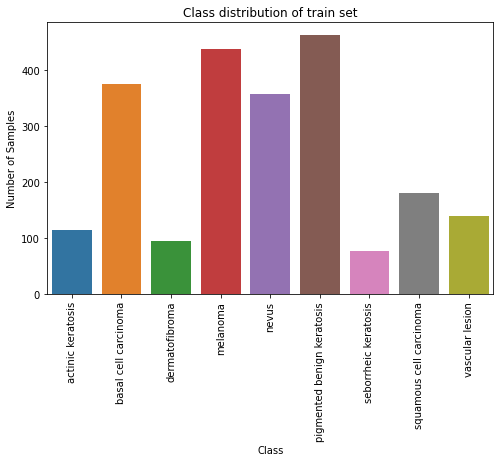

In [46]:
plt.figure(figsize=(8, 5))
sns.barplot(class_names, num_samples_per_class)
plt.title("Class distribution of train set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()


- 'seborrheic keratosis' has the least number of samples (pink)
- 'pigmented benign keratosis' has the most number of samples (brown)

Let's use `Augmentor` (https://augmentor.readthedocs.io/en/master/) library to add more samples across all classes so that none of the classes have very few samples.

In [50]:
data_dir_train

PosixPath('/content/drive/MyDrive/Data/Melanoma_Detection_Data/Train')

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [51]:
path_to_train_set = "/content/drive/MyDrive/Data/Melanoma_Detection_Data/Train"
for class_name in class_names:
    p = Augmentor.Pipeline(f"{path_to_train_set}/{class_name}")
    p.flip_left_right(probability=0.5)
    p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB8848E890>: 100%|██████████| 500/500 [00:22<00:00, 22.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB88477ED0>: 100%|██████████| 500/500 [00:23<00:00, 21.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB88047810>: 100%|██████████| 500/500 [00:22<00:00, 21.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB90D2F050>: 100%|██████████| 500/500 [01:47<00:00,  4.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FDB90E97F50>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB90DE8810>: 100%|██████████| 500/500 [00:24<00:00, 20.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB90DE8050>: 100%|██████████| 500/500 [00:53<00:00,  9.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB90103B50>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Melanoma_Detection_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB881D0550>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [53]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Let's see the distribution of augmented data after adding new images to the original training data.

In [58]:
class_dist_after_data_aug = []
for i, class_name in enumerate(class_names):
    new_samples = os.listdir(f"{data_dir_train}/{class_name}/output")
    class_dist_after_data_aug.append(num_samples_per_class[i] + len(new_samples))
class_dist_after_data_aug

[614, 876, 595, 938, 857, 962, 577, 681, 639]

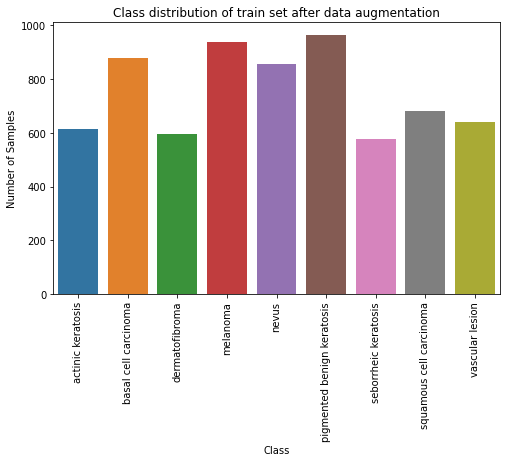

In [59]:
plt.figure(figsize=(8, 5))
sns.barplot(class_names, class_dist_after_data_aug)
plt.title("Class distribution of train set after data augmentation")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

The class distribution has improved a lot after adding 500 images to each class

#### Train the model on the data created using Augmentor

In [63]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [66]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [67]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model

- We are adding another Convolution layer with 256 feature maps because last model was underfitting
- We are also adding L1 and L2 regularization in order to mitigate overfitting

In [88]:
model_3 = keras.Sequential([
                          layers.Rescaling(1./255),
                          layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(64, 3, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(128, 3, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Conv2D(256, 3, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
                          layers.MaxPooling2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dropout(0.5),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(9, activation="softmax")
])

#### Compile model

In [89]:
model_3.compile(optimizer="rmsprop",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

#### Train model

In [90]:
history = model_3.fit(train_ds,
                      epochs=30,
                      validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 35s 195ms/step - loss: 2.2578 - accuracy: 0.1947 - val_loss: 1.9866 - val_accuracy: 0.2546
Epoch 2/30
169/169 [==============================] - 33s 190ms/step - loss: 1.8419 - accuracy: 0.3170 - val_loss: 1.7008 - val_accuracy: 0.3712
Epoch 3/30
169/169 [==============================] - 32s 184ms/step - loss: 1.6921 - accuracy: 0.3733 - val_loss: 1.6025 - val_accuracy: 0.3786
Epoch 4/30
169/169 [==============================] - 32s 186ms/step - loss: 1.6013 - accuracy: 0.4076 - val_loss: 1.4706 - val_accuracy: 0.4840
Epoch 5/30
169/169 [==============================] - 32s 184ms/step - loss: 1.5399 - accuracy: 0.4336 - val_loss: 2.0285 - val_accuracy: 0.3348
Epoch 6/30
169/169 [==============================] - 32s 185ms/step - loss: 1.4815 - accuracy: 0.4429 - val_loss: 1.7293 - val_accuracy: 0.3571
Epoch 7/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4625 - accuracy: 0.4690 - val_loss: 1.5093 - val_ac

#### Visualize the model results

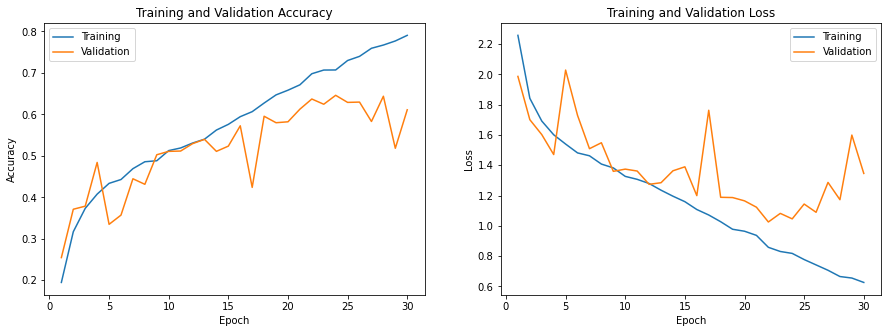

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 31)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- Initially, model 3 was overfitting but after applying L1 and L2 regularization on every convolution layer, it is much better
- Data augmentation definitely helped the model perform better overall 
- The model was able to achieve a validation accuracy of close to 65% but we can improve